In [1]:
import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pickle 
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelBinarizer
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score,mean_squared_error,classification_report,roc_curve,auc
from sklearn.model_selection import GridSearchCV ,train_test_split
df=pd.read_csv("D:/copperman/copperman.csv")
df.columns


C:\Users\puliv\AppData\Local\Temp\ipykernel_6152\1646398085.py:10: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("D:/copperman/copperman.csv")


Index(['id', 'item_date', 'quantity tons', 'customer', 'country', 'status',
       'item type', 'application', 'thickness', 'width', 'material_ref',
       'product_ref', 'delivery date', 'selling_price'],
      dtype='object')

In [2]:
print(df.shape)
print(df.size)

(181673, 14)
2543422


In [3]:
df.rename(columns={"quantity tons":"tons_quantity",
                   "item type":"item_type",
                   "delivery date":"delivery_date"},inplace=True)


In [4]:
df.isnull().sum()

id                   2
item_date            1
tons_quantity        0
customer             1
country             28
status               2
item_type            0
application         24
thickness            1
width                0
material_ref     77919
product_ref          0
delivery_date        1
selling_price        1
dtype: int64

In [5]:

df["country"]==df["country"].fillna(0,inplace=True)
df["country"]=df["country"].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             181671 non-null  object 
 1   item_date      181672 non-null  float64
 2   tons_quantity  181673 non-null  object 
 3   customer       181672 non-null  float64
 4   country        181673 non-null  int32  
 5   status         181671 non-null  object 
 6   item_type      181673 non-null  object 
 7   application    181649 non-null  float64
 8   thickness      181672 non-null  float64
 9   width          181673 non-null  float64
 10  material_ref   103754 non-null  object 
 11  product_ref    181673 non-null  int64  
 12  delivery_date  181672 non-null  float64
 13  selling_price  181672 non-null  float64
dtypes: float64(7), int32(1), int64(1), object(5)
memory usage: 18.7+ MB


In [6]:
df.columns

Index(['id', 'item_date', 'tons_quantity', 'customer', 'country', 'status',
       'item_type', 'application', 'thickness', 'width', 'material_ref',
       'product_ref', 'delivery_date', 'selling_price'],
      dtype='object')

In [7]:
df["item_type"]

0          W
1          W
2         WI
3          S
4          W
          ..
181668     W
181669     W
181670     W
181671     W
181672     W
Name: item_type, Length: 181673, dtype: object

In [8]:
df["tons_quantity"]=pd.to_numeric(df["tons_quantity"],errors='coerce')
df["customer"]=pd.to_numeric(df["customer"],errors='coerce')
df["country"]=pd.to_numeric(df["country"],errors='coerce')
df["application"]=pd.to_numeric(df['application'],errors='coerce')
df["thickness"]=pd.to_numeric(df['thickness'],errors='coerce')
df["width"]=pd.to_numeric(df['width'],errors='coerce')
df["item_date"]=pd.to_datetime(df['item_date'],format='%Y%m%d',errors='coerce').dt.date
df["delivery_date"]=pd.to_datetime(df['delivery_date'],format='%Y%m%d',errors='coerce').dt.date
df["product_ref"]=pd.to_numeric(df['product_ref'],errors='coerce')
df["material_ref"]=df["material_ref"].str.lstrip('0')


In [9]:
df.isnull().sum()

id                   2
item_date            3
tons_quantity        1
customer             1
country              0
status               2
item_type            0
application         24
thickness            1
width                0
material_ref     77919
product_ref          0
delivery_date        3
selling_price        1
dtype: int64

In [10]:
missing_values_count = df.isnull().sum()
print(missing_values_count)
print(df.shape)
df.info()

id                   2
item_date            3
tons_quantity        1
customer             1
country              0
status               2
item_type            0
application         24
thickness            1
width                0
material_ref     77919
product_ref          0
delivery_date        3
selling_price        1
dtype: int64
(181673, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             181671 non-null  object 
 1   item_date      181670 non-null  object 
 2   tons_quantity  181672 non-null  float64
 3   customer       181672 non-null  float64
 4   country        181673 non-null  int32  
 5   status         181671 non-null  object 
 6   item_type      181673 non-null  object 
 7   application    181649 non-null  float64
 8   thickness      181672 non-null  float64
 9   width          181673 non-null  float64
 

In [11]:
df['material_ref'].fillna('unknown', inplace=True)
df = df.dropna()

C:\Users\puliv\AppData\Local\Temp\ipykernel_6152\4160083620.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['material_ref'].fillna('unknown', inplace=True)


In [12]:
null_count = df.isnull().sum()
print(null_count)
print(df.shape)

id               0
item_date        0
tons_quantity    0
customer         0
country          0
status           0
item_type        0
application      0
thickness        0
width            0
material_ref     0
product_ref      0
delivery_date    0
selling_price    0
dtype: int64
(181635, 14)


In [13]:
df["tons_quantity"].skew()

424.6463984696823

C:\Users\puliv\AppData\Local\Temp\ipykernel_6152\359259876.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['thickness'])


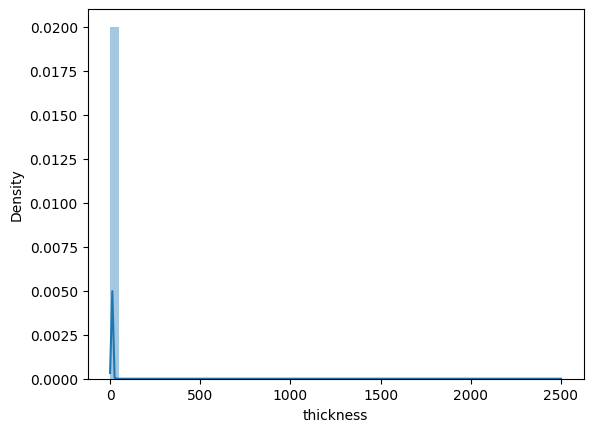

C:\Users\puliv\AppData\Local\Temp\ipykernel_6152\359259876.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['width'])


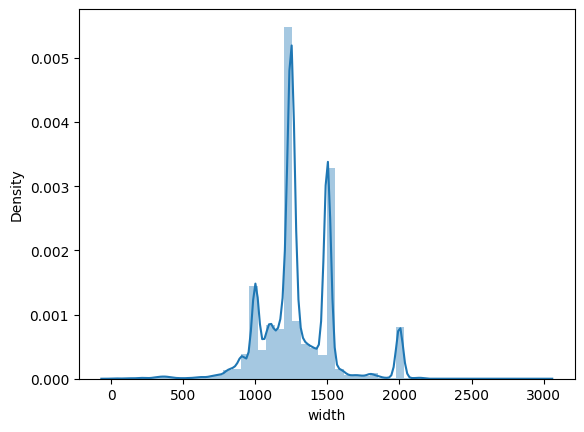

C:\Users\puliv\AppData\Local\Temp\ipykernel_6152\359259876.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['selling_price'])


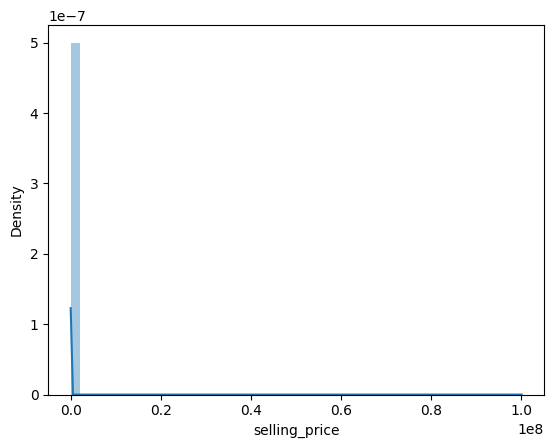

C:\Users\puliv\AppData\Local\Temp\ipykernel_6152\359259876.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['tons_quantity'])


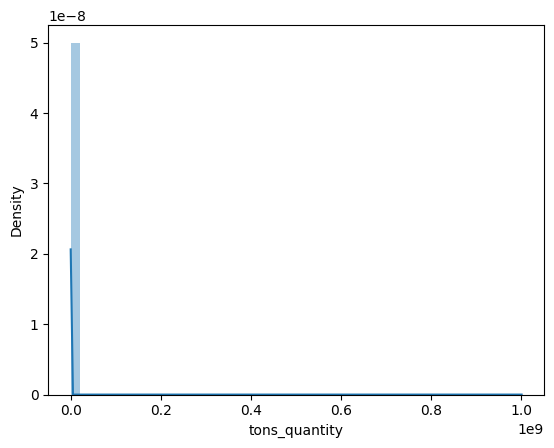

C:\Users\puliv\AppData\Local\Temp\ipykernel_6152\359259876.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['country'])


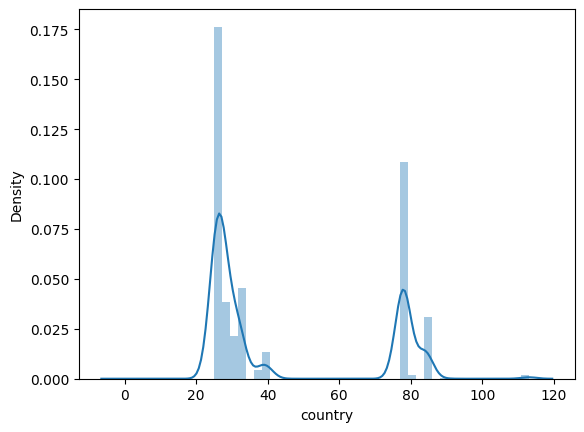

C:\Users\puliv\AppData\Local\Temp\ipykernel_6152\359259876.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['application'])


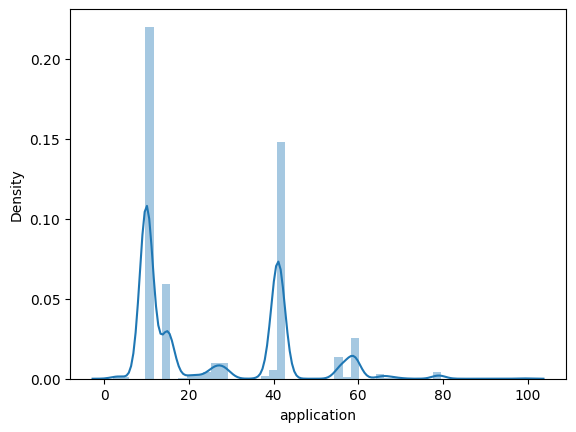

In [14]:
sns.distplot(df['thickness'])
plt.show()
sns.distplot(df['width'])
plt.show()
sns.distplot(df['selling_price'])
plt.show()
sns.distplot(df['tons_quantity'])
plt.show()
sns.distplot(df['country'])
plt.show()
sns.distplot(df['application'])
plt.show()


In [15]:
import numpy as np
negsell= df['selling_price'] <= 0
print(negsell.sum())
df.loc[negsell, 'selling_price'] = np.nan

negtons = df['tons_quantity'] <= 0
print(negtons.sum())
df.loc[negtons, 'tons_quantity'] = np.nan

negth = df['thickness'] <= 0
print(negth.sum())

7
4
0


In [16]:
print(df.isnull().sum())
df.dropna(inplace=True)
print(df.isna().sum())

id               0
item_date        0
tons_quantity    4
customer         0
country          0
status           0
item_type        0
application      0
thickness        0
width            0
material_ref     0
product_ref      0
delivery_date    0
selling_price    7
dtype: int64
id               0
item_date        0
tons_quantity    0
customer         0
country          0
status           0
item_type        0
application      0
thickness        0
width            0
material_ref     0
product_ref      0
delivery_date    0
selling_price    0
dtype: int64


In [17]:
len(df)

181624

C:\Users\puliv\AppData\Local\Temp\ipykernel_6152\706236686.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['tons_quantity_log'].dropna())


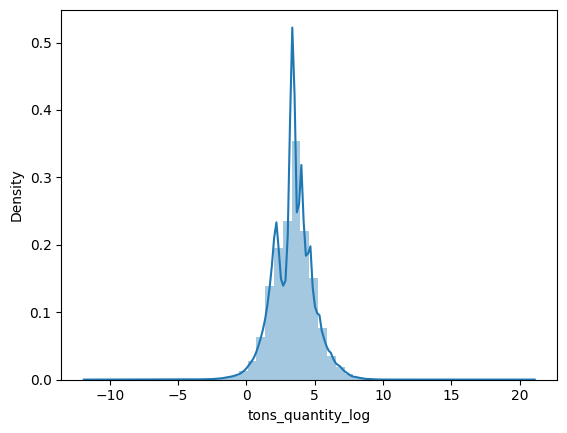

In [18]:
df['tons_quantity'] = df['tons_quantity'].apply(lambda x: np.nan if x <= 0 else x)
# Apply log transformation
df['tons_quantity_log'] = np.log(df['tons_quantity'])
sns.distplot(df['tons_quantity_log'].dropna())
plt.show()

C:\Users\puliv\AppData\Local\Temp\ipykernel_6152\641390259.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['thickness_log'].dropna())


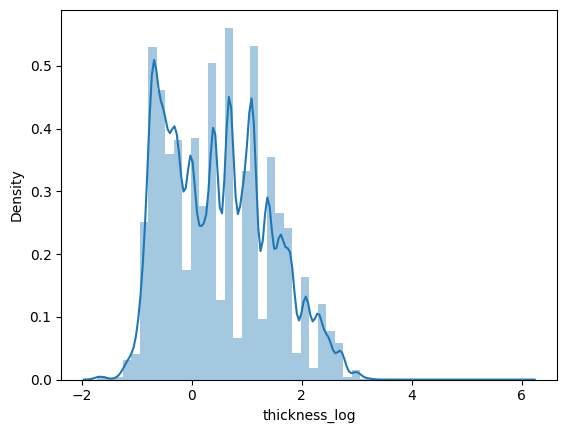

In [19]:
df['thickness_log'] = np.log(df['thickness'])
sns.distplot(df['thickness_log'].dropna())
plt.show()

C:\Users\puliv\AppData\Local\Temp\ipykernel_6152\3582534151.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['selling_price_log'])


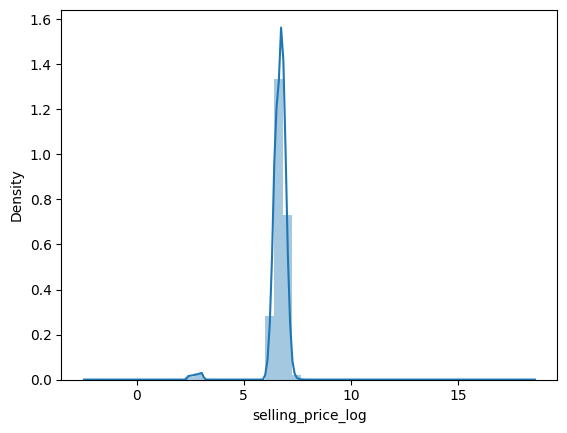

In [20]:
df['selling_price_log'] = np.log(df['selling_price'])  
# Using np.log to handle zero values
sns.distplot(df['selling_price_log'])
plt.show()

<Axes: >

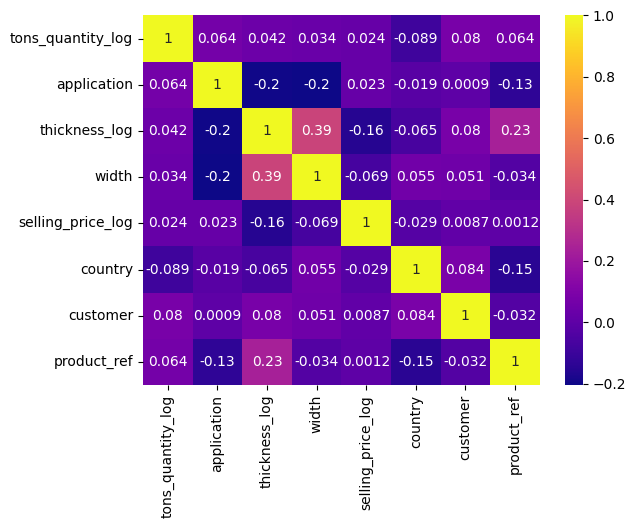

In [21]:
x=df[['tons_quantity_log',
      'application',
      'thickness_log',
      'width','selling_price_log',
      'country',
      'customer',
      'product_ref']].corr()
sns.heatmap(x, annot=True,cmap='plasma')

In [22]:
df_cleaned = df.dropna(subset=['selling_price_log'])

# Separate categorical values (X) and target variable (y)
X = df_cleaned.drop('selling_price_log', axis=1)
y = df_cleaned['selling_price_log']

In [23]:
# encoding categorical variables
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X[['item_type']])
X_ohe = ohe.fit_transform(X[['item_type']]).toarray()
ohe2 = OneHotEncoder(handle_unknown='ignore')
ohe2.fit(X[['status']])
X_be = ohe2.fit_transform(X[['status']]).toarray()
# independent features after encoding
X = np.concatenate((X[['tons_quantity_log',
                       'application',
                       'thickness_log',
                       'width','country',
                       'customer',
                       'product_ref']].values,
                    X_ohe, X_be), axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
# test and train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [24]:

# decision tree regression
dtr = DecisionTreeRegressor()
# hyperparameters
param_grid = {'max_depth': [3, 5, 9, 17],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt', 'log2']}

In [25]:
# gridsearchcv
grid_search = GridSearchCV(estimator=dtr, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

C:\Users\puliv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\puliv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\puliv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-p

Best hyperparameters: {'max_depth': 17, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2}


In [26]:
# evalution metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean squared error:', mse)
print('R-squared:', r2)

Mean squared error: 0.03078210915311316
R-squared: 0.9042968724595393


In [27]:
df["item_type"].unique()

array(['W', 'WI', 'S', 'Others', 'PL', 'IPL', 'SLAWR'], dtype=object)

In [28]:
df["width"].describe()

count    181624.000000
mean       1295.269028
std         261.648269
min           1.000000
25%        1180.000000
50%        1250.000000
75%        1500.000000
max        2990.000000
Name: width, dtype: float64

In [29]:
sample = np.array([[np.log(40),99 , np.log(2),
                        5, 28,30202938,
                        1670798778,'PL','']])
sample

array([['3.6888794541139363', '99', '0.6931471805599453', '5', '28',
        '30202938', '1670798778', 'PL', '']], dtype='<U32')

In [30]:

new_sample_ohe = ohe.transform(sample[:, [7]]).toarray()
new_sample_be = ohe2.transform(sample[:, [8]]).toarray()
new_sample = np.concatenate((sample[:, [0,1,2, 3, 4, 5, 6]],
                             new_sample_ohe,new_sample_be), axis=1)
sc_sample1 = scaler.transform(new_sample)
new_pred = best_model.predict(sc_sample1)
print('Predicted selling price:', np.exp(new_pred))

Predicted selling price: [528.46778521]


C:\Users\puliv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
C:\Users\puliv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [31]:
#uncomment to pickle the decision tree model,standard scaler,one hot encoders,
'''
with open('decisiontreemodel.pkl', 'wb') as file:
    pickle.dump(best_model, file)
with open('standardscaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('onehotencoder.pkl', 'wb') as f:
    pickle.dump(ohe, f)
with open('onehotencoder2.pkl', 'wb') as f:
    pickle.dump(ohe2, f)'''

"\nwith open('decisiontreemodel.pkl', 'wb') as file:\n    pickle.dump(best_model, file)\nwith open('standardscaler.pkl', 'wb') as f:\n    pickle.dump(scaler, f)\nwith open('onehotencoder.pkl', 'wb') as f:\n    pickle.dump(ohe, f)\nwith open('onehotencoder2.pkl', 'wb') as f:\n    pickle.dump(ohe2, f)"

In [32]:
print(len(df_cleaned))
df_cleaned.head(3)

181624


,id,item_date,tons_quantity,customer,country,status,item_type,application,thickness,width,material_ref,product_ref,delivery_date,selling_price,tons_quantity_log,thickness_log,selling_price_log
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,2021-04-01,54.151139,30156308.0,28,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,2021-07-01,854.00,3.991779,0.693147,6.749931
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,2021-04-01,768.024839,30202938.0,25,Won,W,41.0,0.80,1210.0,104991,1668701718,2021-04-01,1047.00,6.643822,-0.223144,6.953684
2,E140FF1B-2407-4C02-A0DD-780A093B1158,2021-04-01,386.127949,30153963.0,30,Won,WI,28.0,0.38,952.0,S0380700,628377,2021-01-01,644.33,5.956169,-0.967584,6.468211


In [33]:
dfc = df_cleaned[df_cleaned['status'].isin(['Won', 'Lost'])]
len(dfc)

150428

In [34]:
dfc.isna().sum()

id                   0
item_date            0
tons_quantity        0
customer             0
country              0
status               0
item_type            0
application          0
thickness            0
width                0
material_ref         0
product_ref          0
delivery_date        0
selling_price        0
tons_quantity_log    0
thickness_log        0
selling_price_log    0
dtype: int64

In [35]:
#df_4.to_csv("D:/copperman/dataframe_coppermodel.csv",index=False)
dfc.head()

,id,item_date,tons_quantity,customer,country,status,item_type,application,thickness,width,material_ref,product_ref,delivery_date,selling_price,tons_quantity_log,thickness_log,selling_price_log
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,2021-04-01,54.151139,30156308.0,28,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,2021-07-01,854.00,3.991779,0.693147,6.749931
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,2021-04-01,768.024839,30202938.0,25,Won,W,41.0,0.80,1210.0,104991,1668701718,2021-04-01,1047.00,6.643822,-0.223144,6.953684
2,E140FF1B-2407-4C02-A0DD-780A093B1158,2021-04-01,386.127949,30153963.0,30,Won,WI,28.0,0.38,952.0,S0380700,628377,2021-01-01,644.33,5.956169,-0.967584,6.468211
3,F8D507A0-9C62-4EFE-831E-33E1DA53BB50,2021-04-01,202.411065,30349574.0,32,Won,S,59.0,2.30,1317.0,DX51D+ZM310MAO 2.3X1317,1668701718,2021-01-01,768.00,5.310301,0.832909,6.643790
4,4E1C4E78-152B-430A-8094-ADD889C9D0AD,2021-04-01,785.526262,30211560.0,28,Won,W,10.0,4.00,2000.0,2_S275JR+AR-CL1,640665,2021-03-01,577.00,6.666354,1.386294,6.357842


In [36]:
Y = dfc['status']
X= dfc[['tons_quantity_log','selling_price_log',
         'item_type','application','thickness_log',
         'width','country','customer','product_ref']]
# encoding categorical variables
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X[['item_type']])
X_ohe = ohe.fit_transform(X[['item_type']]).toarray()
be = LabelBinarizer()
be.fit(Y) 
y = be.fit_transform(Y)

In [37]:
# categorical values after encoding
X = np.concatenate((X[['tons_quantity_log', 'selling_price_log','application',
                       'thickness_log', 'width','country',
                       'customer','product_ref']].values, X_ohe), axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)
# decision tree classifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

Accuracy: 0.9073323140331051
Confusion Matrix:
[[ 8313  2047]
 [ 2135 32634]]


Confusion Matrix:
[[ 8313  2047]
 [ 2135 32634]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     10360
           1       0.94      0.94      0.94     34769

    accuracy                           0.91     45129
   macro avg       0.87      0.87      0.87     45129
weighted avg       0.91      0.91      0.91     45129



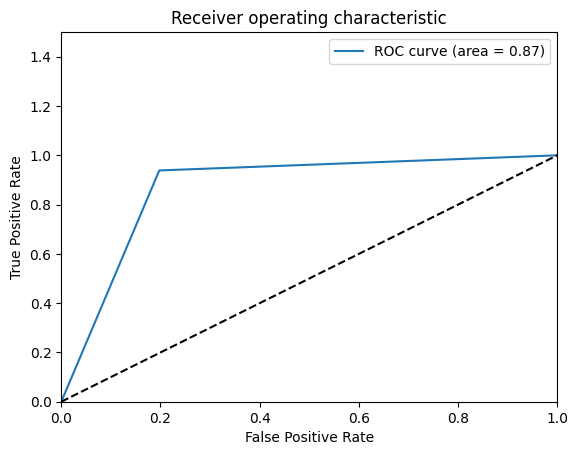

In [38]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.5])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="upper right")

plt.show()

In [39]:
# Predict the status for a new sample
# 'quantity tons_log', 'selling_price_log','application', 'thickness_log', 'width','country','customer','product_ref'
new_sample = np.array([[np.log(700), np.log(956), 10, np.log(2),1500,28.0,30202938,1670798778,'W']])
new_sample_ohe = ohe.transform(new_sample[:, [8]]).toarray()
new_sample = np.concatenate((new_sample[:, [0,1,2, 3, 4, 5, 6,7]], new_sample_ohe), axis=1)
new_sample = scaler.transform(new_sample)
new_pred = dtc.predict(new_sample)
if new_pred==1:
    print('The status is: Won')
else:
    print('The status is: Lost')

The status is: Lost


C:\Users\puliv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [40]:
'''
# Saving the model
import pickle
with open('classificationmodel.pkl', 'wb') as file:
    pickle.dump(dtc, file)
with open('classificationscaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('classification_encoder_t.pkl', 'wb') as f:
    pickle.dump(ohe, f)'''

"\n# Saving the model\nimport pickle\nwith open('classificationmodel.pkl', 'wb') as file:\n    pickle.dump(dtc, file)\nwith open('classificationscaler.pkl', 'wb') as f:\n    pickle.dump(scaler, f)\nwith open('classification_encoder_t.pkl', 'wb') as f:\n    pickle.dump(ohe, f)"